In [1]:
import numpy as np
import random as rm
import pandas as pd
from random import seed
from random import random
import matplotlib.pyplot as plt
from pylab import *
from scipy.optimize import curve_fit
from scipy.stats import bernoulli, binom, norm
from scipy import integrate

In [2]:
def simulate(mu_list, sigma_list, alpha_list, n, p, x0, y0, sigma, epsilon):
    def f_pi(x):
        val = 0
        for i in range(len(mu_list)):
            val += alpha_list[i]*norm.pdf(x,mu_list[i], sigma_list[i]**0.5)
        return val
    # y value on point x of the f_pi(x) curve
    
    def pdf_eta(x):
        return f_pi(x)**p
    # y value on point x of the pdf_eta(x) curve

    c = integrate.quad(pdf_eta, -np.inf, np.inf)[0]
    
    def f_eta(x):
        return pdf_eta(x)/c
    
    def g(x):
        return(f_pi(x)/f_eta(x))
    
    
    def p_kernel(y0, sigma, n):
        count = 0
        Yn = y0
        estimator = [y0]
        while count<n:
            y = np.random.normal(Yn, sigma)
            u = np.random.uniform(0,1)
            alpha = min((pdf_eta(y)/pdf_eta(Yn)),1)
            if u <= alpha:
                estimator.append(y)
                Yn = y
                count +=1
        return estimator

    def k_kernel(x0, sigma):
        count = 0
        Xn = x0
        estimator = [x0]
        while count<1:
            y = np.random.normal(Xn,sigma)
            u = np.random.uniform(0,1)
            alpha = min((pdf_eta(y)/pdf_eta(Xn)),1)
            if u <= alpha:
                estimator.append(y)
                Xn = y
                count +=1
        return estimator[-1]
    
    def sum_g(sum_old, yn):
        sum_new = sum_old + g(yn)
        return sum_new

    def prob_list(y, sum_new):
        prob_list = []
        for i in y:
            prob_list.append(g(i)/sum_new)
        return prob_list
    
    def bernoulli_list(epsilon, n):
        b_list = bernoulli(epsilon).rvs(n)
        return b_list
    
    def x_sample(x0, epsilon, y0, n, sigma):
        X_list = [x0]
        Y_list = [y0]
        sum_gs = g(y0)
        Y_list = p_kernel(y0,sigma,n)
        for k in range(1, n):
            sum_gs = sum_g(sum_gs, Y_list[k])
            prob_list_Ys = prob_list(Y_list[:k+1], sum_gs)
            bernoullis = bernoulli_list(epsilon, 1)
            i = bernoullis
            if i == 0:
                X_list.append(k_kernel(x0, sigma))
            if i == 1:
                X_list.append(np.random.choice(Y_list[:k+1], p = prob_list_Ys))
            x0 = X_list[-1]
        return X_list
    
    def E_x(X_list):
        sum = 0
        for i in X_list:
            sum += i
        mean = sum/len(X_list)
        return mean
    
    X_list = x_sample(x0, epsilon, y0, n, sigma)
    X_mean = E_x(X_list)
    
    return [X_list, X_mean]

In [7]:
mu_list = [0,17.5]        # mean list of target distribution
sigma_list = [.5,1]       # variance list of target distribtuion
alpha_list = [0.4,0.6]    # constant list of target distribution
p = 0.75                  # the rate coefficient between target distribution and proposed distribution
n = 100                   # number of simulations
y0 =15                    # initial position of y
x0 = 10                   # initial position of x
sigma = 10                # standard deviation within P and K kernel
epsilon = 0.05            # coefficients of algorithm1

X_list = simulate(mu_list, sigma_list, alpha_list, n, p, x0, y0, sigma, epsilon)[0]
mean_value = simulate(mu_list, sigma_list, alpha_list, n, p, x0, y0, sigma, epsilon)[1]


In [8]:
print(mean_value)

10.852103603040389


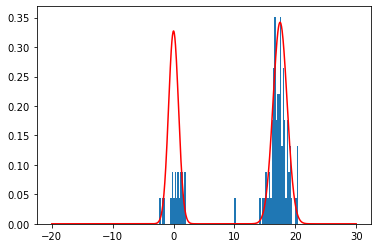

In [6]:
pdf_eta = lambda x: np.power(0.4*(1/np.sqrt(2*math.pi*0.5))*np.exp((-1/2)*((x-0)**2/0.5)) + 0.6*(1/np.sqrt(2*math.pi*1))*np.exp((-1/2)*((x-17.5)**2/1)),0.75)

plt.hist(X_list, density = True, bins = 100)
t = np.linspace(-20,30,1000)
vals = pdf_eta(t)
plt.plot(t,vals, 'r')